## 1. Setup and Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries loaded successfully")
print(f"Analysis timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries loaded successfully
Analysis timestamp: 2026-01-15 19:59:59


In [2]:
# Load Layer 1 migration metrics
layer1_path = Path('../outputs/layer1_migration_metrics.csv')
monthly_path = Path('../outputs/df_monthly_district.csv')

if not layer1_path.exists():
    raise FileNotFoundError(f"Layer 1 metrics not found: {layer1_path}")
if not monthly_path.exists():
    raise FileNotFoundError(f"Monthly data not found: {monthly_path}")

# Load data
df_layer1 = pd.read_csv(layer1_path)
df_monthly = pd.read_csv(monthly_path)

print(f"Layer 1 metrics loaded: {len(df_layer1):,} districts")
print(f"Monthly data loaded: {len(df_monthly):,} records")
print(f"\nLayer 1 columns: {list(df_layer1.columns)}")
print(f"\nMonthly data columns: {list(df_monthly.columns)}")

Layer 1 metrics loaded: 1,056 districts
Monthly data loaded: 7,062 records

Layer 1 columns: ['district', 'state', 'mean_adult_updates', 'volatility', 'avg_growth_rate', 'max_growth_rate', 'spike_amplitude', 'coefficient_variation', 'baseline_volume', 'migration_pressure_score', 'migration_pattern', 'num_months', 'vol_norm', 'growth_norm', 'baseline_inv_norm', 'high_churn']

Monthly data columns: ['year_month', 'state', 'district', 'demo_age_5_17', 'demo_age_17_', 'record_count', 'pincode_count', 'total_updates', 'child_update_share']


In [3]:
# Verify required columns
required_layer1 = ['district', 'state', 'coefficient_variation', 'mean_adult_updates', 'baseline_volume']
required_monthly = ['year_month', 'state', 'district', 'demo_age_17_']

missing_layer1 = [col for col in required_layer1 if col not in df_layer1.columns]
missing_monthly = [col for col in required_monthly if col not in df_monthly.columns]

if missing_layer1:
    raise ValueError(f"Missing Layer 1 columns: {missing_layer1}")
if missing_monthly:
    raise ValueError(f"Missing monthly columns: {missing_monthly}")

print("✓ All required columns present")
print(f"\nData quality check:")
print(f"  Layer 1 nulls: {df_layer1[required_layer1].isnull().sum().sum()}")
print(f"  Monthly nulls: {df_monthly[required_monthly].isnull().sum().sum()}")

✓ All required columns present

Data quality check:
  Layer 1 nulls: 0
  Monthly nulls: 0


## 2. Calculate DSI (Demographic Stability Index)

In [4]:
# Calculate rolling deviation from monthly data
print("Calculating rolling deviation for DSI...")

# Prepare monthly data
df_monthly_clean = df_monthly[df_monthly['demo_age_17_'].notna()].copy()
df_monthly_clean['year_month'] = pd.to_datetime(df_monthly_clean['year_month'])
df_monthly_clean = df_monthly_clean.sort_values(['state', 'district', 'year_month'])

# Calculate 3-month rolling standard deviation
rolling_std = []
for (state, district), group in df_monthly_clean.groupby(['state', 'district']):
    if len(group) >= 3:
        std_val = group['demo_age_17_'].rolling(window=3, min_periods=3).std().mean()
        mean_val = group['demo_age_17_'].mean()
        rolling_std.append({
            'state': state,
            'district': district,
            'rolling_std': std_val,
            'mean_value': mean_val,
            'rolling_deviation': std_val / mean_val if mean_val > 0 else 0
        })

df_rolling = pd.DataFrame(rolling_std)
print(f"Rolling deviation calculated for {len(df_rolling):,} districts")

Calculating rolling deviation for DSI...


Rolling deviation calculated for 1,009 districts


In [5]:
# Merge rolling deviation with Layer 1 data
df_dsi = df_layer1.merge(df_rolling, on=['state', 'district'], how='left')

# Fill missing rolling_deviation with mean
df_dsi['rolling_deviation'] = df_dsi['rolling_deviation'].fillna(df_dsi['rolling_deviation'].mean())

# Normalize components for DSI
cv_max = df_dsi['coefficient_variation'].max()
cv_min = df_dsi['coefficient_variation'].min()
df_dsi['normalized_cv'] = (df_dsi['coefficient_variation'] - cv_min) / (cv_max - cv_min)

rd_max = df_dsi['rolling_deviation'].max()
rd_min = df_dsi['rolling_deviation'].min()
df_dsi['normalized_deviation'] = (df_dsi['rolling_deviation'] - rd_min) / (rd_max - rd_min)

# Calculate DSI: 0-100 scale (higher = more stable)
df_dsi['DSI'] = (
    0.6 * (1 - df_dsi['normalized_cv']) + 
    0.4 * (1 - df_dsi['normalized_deviation'])
) * 100

# DSI Classification
def classify_dsi(dsi):
    if dsi >= 80:
        return 'Very High'
    elif dsi >= 60:
        return 'High'
    elif dsi >= 40:
        return 'Moderate'
    elif dsi >= 20:
        return 'Low'
    else:
        return 'Very Low'

df_dsi['DSI_Classification'] = df_dsi['DSI'].apply(classify_dsi)

print(f"\nDSI Statistics:")
print(df_dsi['DSI'].describe())
print(f"\nDSI Classification Distribution:")
print(df_dsi['DSI_Classification'].value_counts().sort_index())


DSI Statistics:
count    1056.000000
mean       68.193616
std        11.005283
min         8.283372
25%        63.956767
50%        69.806514
75%        74.276324
max        96.108314
Name: DSI, dtype: float64

DSI Classification Distribution:
DSI_Classification
High         796
Low           28
Moderate     159
Very High     70
Very Low       3
Name: count, dtype: int64


## 3. Calculate ADP (Aadhaar Dependency Proxy)

In [6]:
# Calculate persistence: % months above mean
print("Calculating persistence for ADP...")

persistence_scores = []
for (state, district), group in df_monthly_clean.groupby(['state', 'district']):
    mean_val = group['demo_age_17_'].mean()
    above_mean = (group['demo_age_17_'] >= mean_val).sum()
    total_months = len(group)
    persistence = (above_mean / total_months * 100) if total_months > 0 else 50.0
    
    persistence_scores.append({
        'state': state,
        'district': district,
        'persistence': persistence,
        'months_above_mean': above_mean,
        'total_months': total_months
    })

df_persistence = pd.DataFrame(persistence_scores)
print(f"Persistence calculated for {len(df_persistence):,} districts")

Calculating persistence for ADP...


Persistence calculated for 1,056 districts


In [7]:
# Merge persistence with DSI data
df_adp = df_dsi.merge(df_persistence, on=['state', 'district'], how='left')

# Fill missing persistence with 50 (neutral)
df_adp['persistence'] = df_adp['persistence'].fillna(50.0)

# Calculate ADP components
# 1. Baseline score: normalize mean_adult_updates
baseline_max = df_adp['mean_adult_updates'].max()
baseline_min = df_adp['mean_adult_updates'].min()
df_adp['baseline_score'] = ((df_adp['mean_adult_updates'] - baseline_min) / 
                             (baseline_max - baseline_min)) * 100

# 2. Consistency score: inverse of CV (already normalized)
df_adp['consistency_score'] = (1 - df_adp['normalized_cv']) * 100

# 3. Persistence score: already in 0-100 range
df_adp['persistence_score'] = df_adp['persistence']

# Calculate ADP: weighted average
df_adp['ADP'] = (
    0.50 * df_adp['baseline_score'] +
    0.30 * df_adp['consistency_score'] +
    0.20 * df_adp['persistence_score']
)

# ADP Classification
def classify_adp(adp):
    if adp >= 80:
        return 'Very High'
    elif adp >= 60:
        return 'High'
    elif adp >= 40:
        return 'Moderate'
    elif adp >= 20:
        return 'Low'
    else:
        return 'Very Low'

df_adp['ADP_Classification'] = df_adp['ADP'].apply(classify_adp)

print(f"\nADP Statistics:")
print(df_adp['ADP'].describe())
print(f"\nADP Classification Distribution:")
print(df_adp['ADP_Classification'].value_counts().sort_index())


ADP Statistics:
count    1056.000000
mean       36.037941
std         9.628581
min         5.092787
25%        30.389574
50%        34.231488
75%        40.120947
max        80.522756
Name: ADP, dtype: float64

ADP Classification Distribution:
ADP_Classification
High          29
Low          771
Moderate     240
Very High      1
Very Low      15
Name: count, dtype: int64


## 4. Integrated System Intelligence Metrics

In [8]:
# Define quadrants based on DSI and ADP
def assign_quadrant(row):
    dsi = row['DSI']
    adp = row['ADP']
    
    if dsi >= 50 and adp >= 50:
        return 'Q1: High Stability, High Dependency'
    elif dsi < 50 and adp >= 50:
        return 'Q2: Low Stability, High Dependency'
    elif dsi < 50 and adp < 50:
        return 'Q3: Low Stability, Low Dependency'
    else:
        return 'Q4: High Stability, Low Dependency'

df_adp['Quadrant'] = df_adp.apply(assign_quadrant, axis=1)

# Identify critical zones (High dependency + Low stability)
df_adp['Critical_Zone'] = ((df_adp['ADP'] >= 60) & (df_adp['DSI'] < 40))

print(f"\nQuadrant Distribution:")
print(df_adp['Quadrant'].value_counts())
print(f"\nCritical Zones: {df_adp['Critical_Zone'].sum()} districts")
print(f"  ({df_adp['Critical_Zone'].sum() / len(df_adp) * 100:.1f}% of total)")


Quadrant Distribution:
Quadrant
Q4: High Stability, Low Dependency     873
Q1: High Stability, High Dependency    118
Q3: Low Stability, Low Dependency       62
Q2: Low Stability, High Dependency       3
Name: count, dtype: int64

Critical Zones: 0 districts
  (0.0% of total)


## 5. Visualization 1: DSI Analysis

✓ DSI analysis saved: ../outputs/layer3_dsi_analysis.png


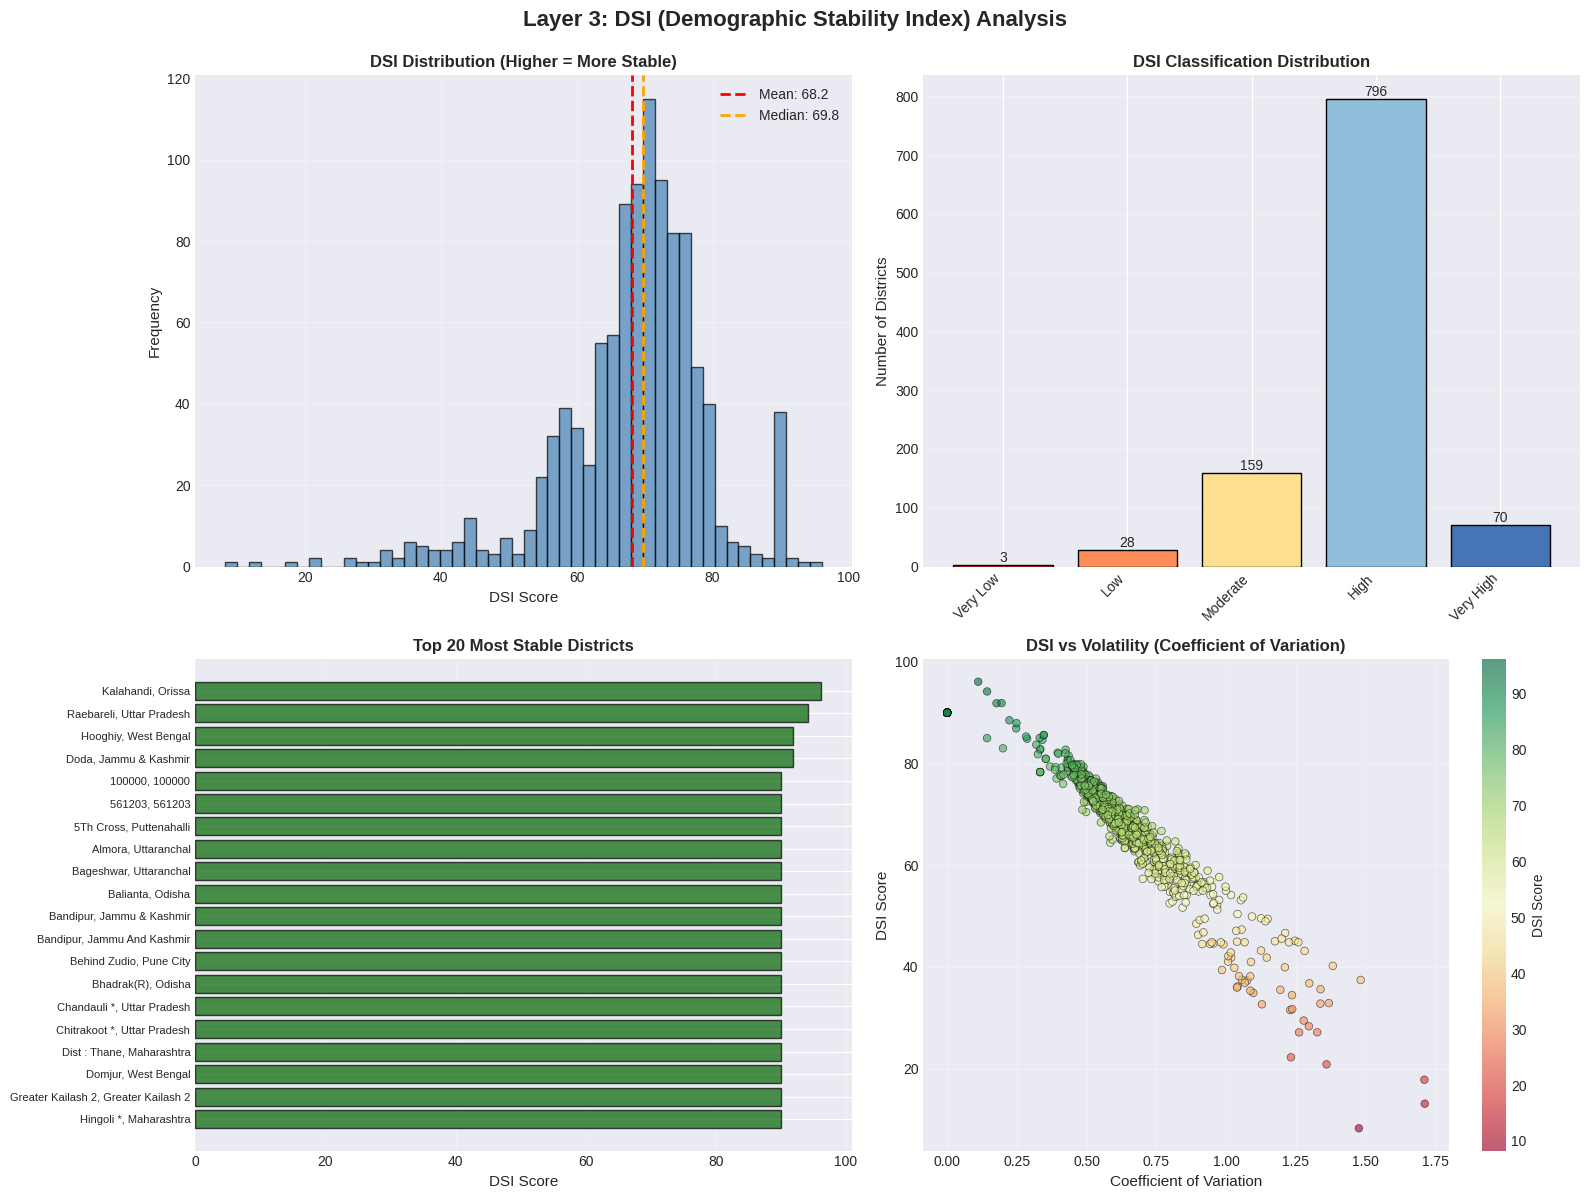

In [9]:
# Create DSI analysis visualization (4 panels)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Layer 3: DSI (Demographic Stability Index) Analysis', fontsize=16, fontweight='bold', y=0.995)

# Panel 1: DSI Distribution
axes[0, 0].hist(df_adp['DSI'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df_adp['DSI'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_adp["DSI"].mean():.1f}')
axes[0, 0].axvline(df_adp['DSI'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_adp["DSI"].median():.1f}')
axes[0, 0].set_xlabel('DSI Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('DSI Distribution (Higher = More Stable)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Panel 2: Classification Breakdown
class_order = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
class_counts = df_adp['DSI_Classification'].value_counts().reindex(class_order, fill_value=0)
colors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']
bars = axes[0, 1].bar(range(len(class_counts)), class_counts.values, color=colors, edgecolor='black')
axes[0, 1].set_xticks(range(len(class_counts)))
axes[0, 1].set_xticklabels(class_counts.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Number of Districts', fontsize=11)
axes[0, 1].set_title('DSI Classification Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Panel 3: Top 20 Most Stable Districts
top20_stable = df_adp.nlargest(20, 'DSI')[['district', 'state', 'DSI']].copy()
top20_stable['label'] = top20_stable['district'] + ', ' + top20_stable['state']
axes[1, 0].barh(range(20), top20_stable['DSI'].values, color='darkgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(20))
axes[1, 0].set_yticklabels(top20_stable['label'].values, fontsize=8)
axes[1, 0].set_xlabel('DSI Score', fontsize=11)
axes[1, 0].set_title('Top 20 Most Stable Districts', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Panel 4: DSI vs Coefficient of Variation
scatter = axes[1, 1].scatter(df_adp['coefficient_variation'], df_adp['DSI'], 
                            c=df_adp['DSI'], cmap='RdYlGn', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[1, 1].set_xlabel('Coefficient of Variation', fontsize=11)
axes[1, 1].set_ylabel('DSI Score', fontsize=11)
axes[1, 1].set_title('DSI vs Volatility (Coefficient of Variation)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='DSI Score')

plt.tight_layout()
output_path = Path('../outputs/layer3_dsi_analysis.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ DSI analysis saved: {output_path}")
plt.show()

## 6. Visualization 2: ADP Analysis

✓ ADP analysis saved: ../outputs/layer3_adp_analysis.png


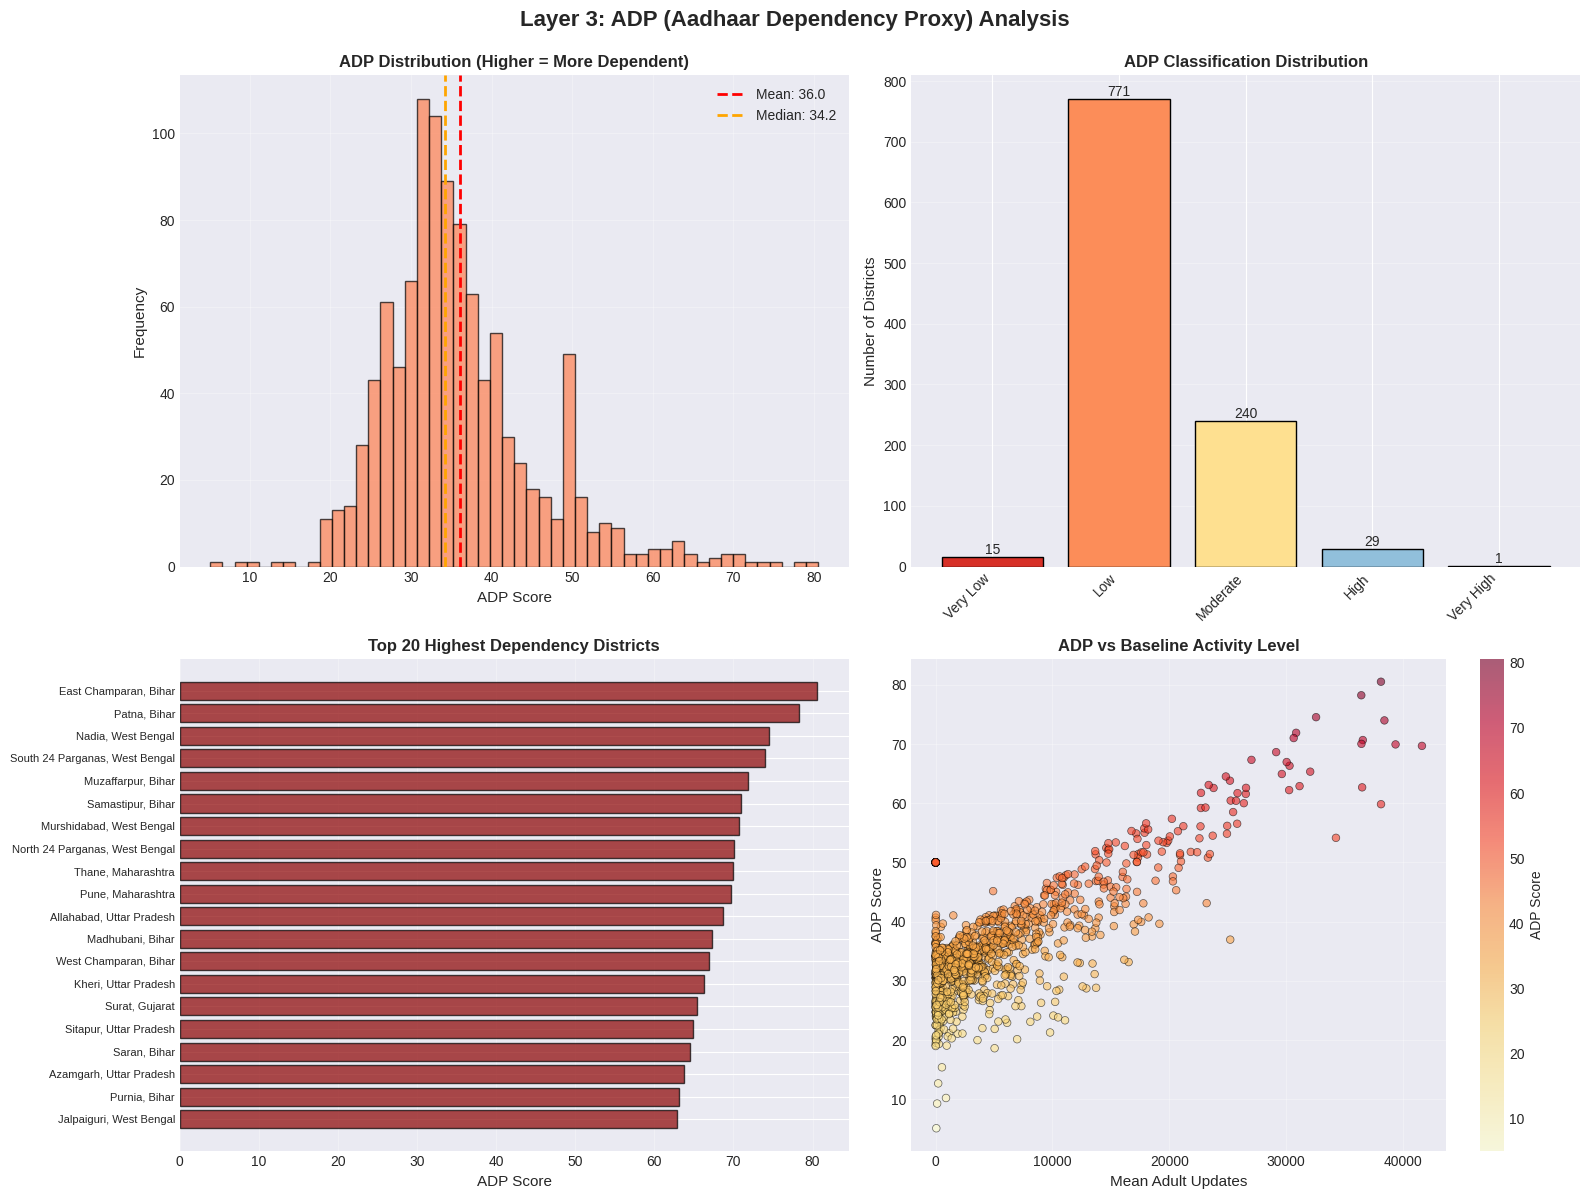

In [10]:
# Create ADP analysis visualization (4 panels)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Layer 3: ADP (Aadhaar Dependency Proxy) Analysis', fontsize=16, fontweight='bold', y=0.995)

# Panel 1: ADP Distribution
axes[0, 0].hist(df_adp['ADP'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df_adp['ADP'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_adp["ADP"].mean():.1f}')
axes[0, 0].axvline(df_adp['ADP'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df_adp["ADP"].median():.1f}')
axes[0, 0].set_xlabel('ADP Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('ADP Distribution (Higher = More Dependent)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Panel 2: Classification Breakdown
class_counts_adp = df_adp['ADP_Classification'].value_counts().reindex(class_order, fill_value=0)
colors_adp = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']
bars = axes[0, 1].bar(range(len(class_counts_adp)), class_counts_adp.values, color=colors_adp, edgecolor='black')
axes[0, 1].set_xticks(range(len(class_counts_adp)))
axes[0, 1].set_xticklabels(class_counts_adp.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Number of Districts', fontsize=11)
axes[0, 1].set_title('ADP Classification Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Panel 3: Top 20 Highest Dependency Districts
top20_dependency = df_adp.nlargest(20, 'ADP')[['district', 'state', 'ADP']].copy()
top20_dependency['label'] = top20_dependency['district'] + ', ' + top20_dependency['state']
axes[1, 0].barh(range(20), top20_dependency['ADP'].values, color='darkred', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(20))
axes[1, 0].set_yticklabels(top20_dependency['label'].values, fontsize=8)
axes[1, 0].set_xlabel('ADP Score', fontsize=11)
axes[1, 0].set_title('Top 20 Highest Dependency Districts', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Panel 4: ADP vs Baseline Activity
scatter = axes[1, 1].scatter(df_adp['mean_adult_updates'], df_adp['ADP'], 
                            c=df_adp['ADP'], cmap='YlOrRd', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
axes[1, 1].set_xlabel('Mean Adult Updates', fontsize=11)
axes[1, 1].set_ylabel('ADP Score', fontsize=11)
axes[1, 1].set_title('ADP vs Baseline Activity Level', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1], label='ADP Score')

plt.tight_layout()
output_path = Path('../outputs/layer3_adp_analysis.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ ADP analysis saved: {output_path}")
plt.show()

## 7. Visualization 3: Integrated Analysis

✓ Integrated analysis saved: ../outputs/layer3_integrated_analysis.png


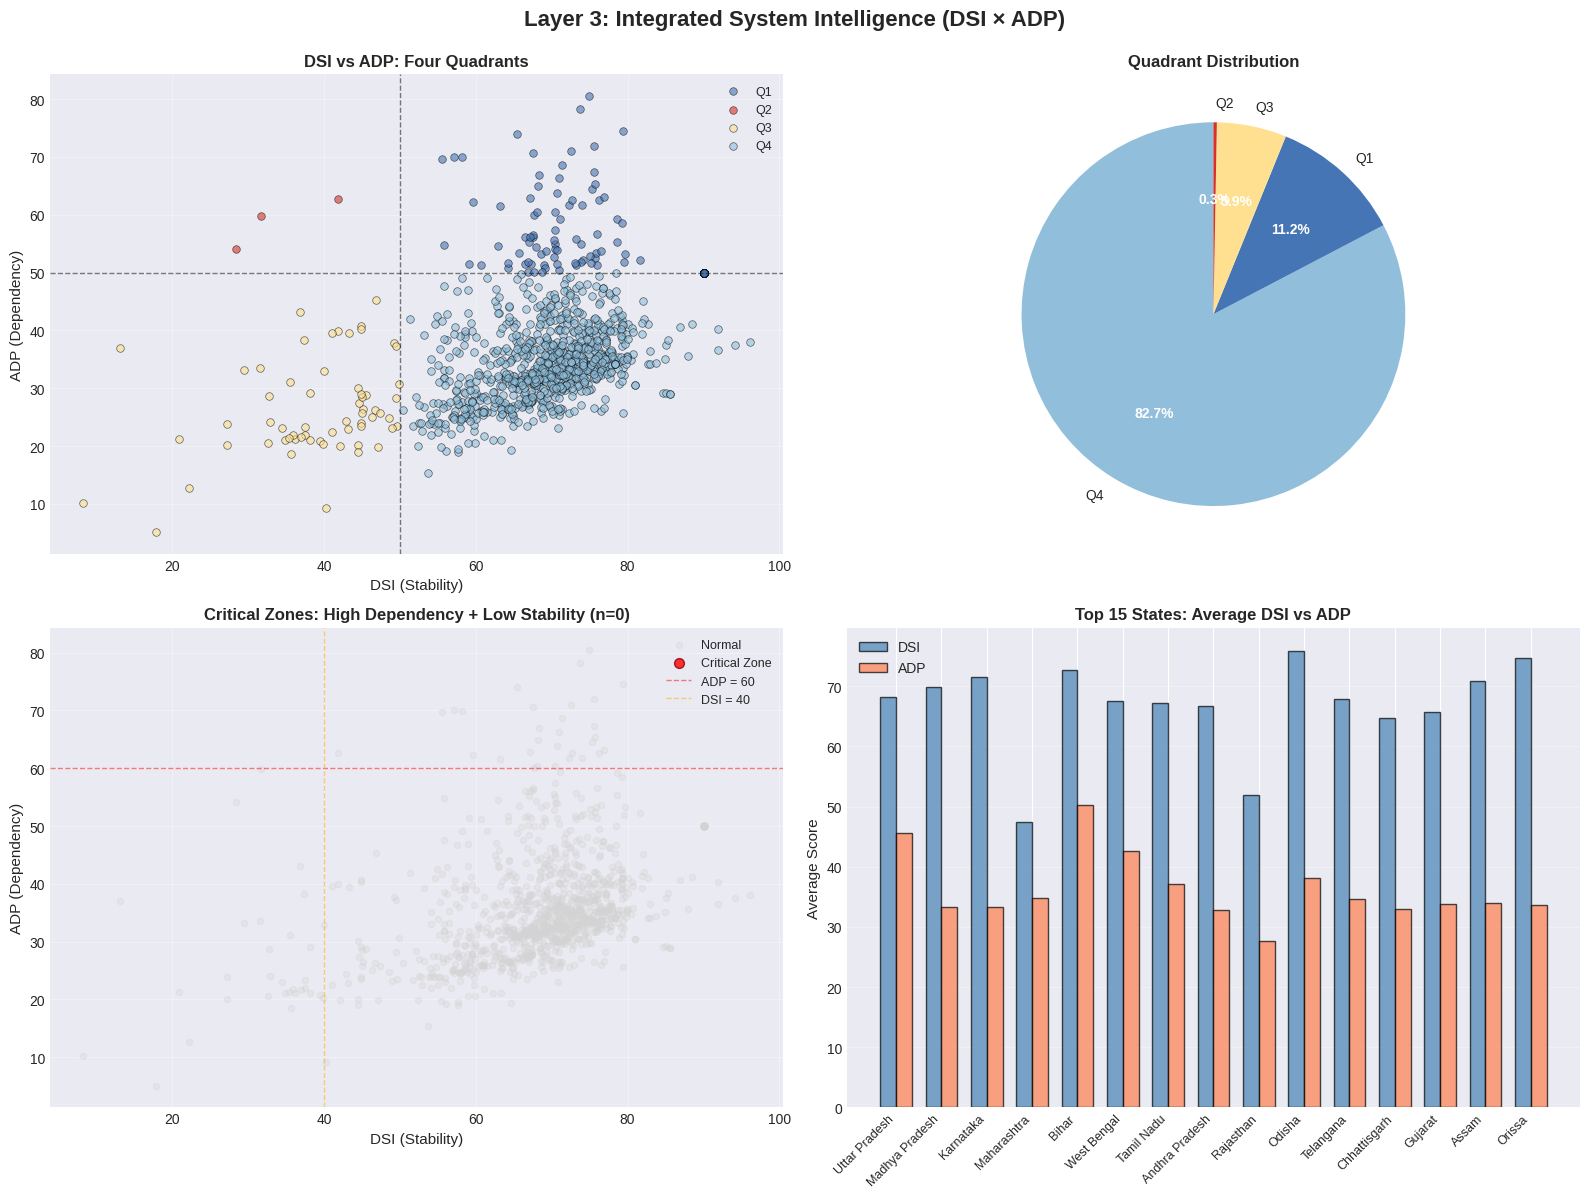

In [11]:
# Create integrated analysis visualization (4 panels)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Layer 3: Integrated System Intelligence (DSI × ADP)', fontsize=16, fontweight='bold', y=0.995)

# Panel 1: DSI vs ADP Quadrant Scatter
quadrant_colors = {
    'Q1: High Stability, High Dependency': '#4575b4',
    'Q2: Low Stability, High Dependency': '#d73027',
    'Q3: Low Stability, Low Dependency': '#fee090',
    'Q4: High Stability, Low Dependency': '#91bfdb'
}
for quadrant, color in quadrant_colors.items():
    mask = df_adp['Quadrant'] == quadrant
    axes[0, 0].scatter(df_adp.loc[mask, 'DSI'], df_adp.loc[mask, 'ADP'], 
                      c=color, label=quadrant.split(':')[0], alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

axes[0, 0].axhline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 0].set_xlabel('DSI (Stability)', fontsize=11)
axes[0, 0].set_ylabel('ADP (Dependency)', fontsize=11)
axes[0, 0].set_title('DSI vs ADP: Four Quadrants', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='best', fontsize=9)
axes[0, 0].grid(alpha=0.3)

# Panel 2: Quadrant Distribution
quadrant_counts = df_adp['Quadrant'].value_counts()
quadrant_labels = [q.split(':')[0] for q in quadrant_counts.index]
colors_quad = [quadrant_colors[q] for q in quadrant_counts.index]
wedges, texts, autotexts = axes[0, 1].pie(quadrant_counts.values, labels=quadrant_labels, 
                                           autopct='%1.1f%%', colors=colors_quad, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[0, 1].set_title('Quadrant Distribution', fontsize=12, fontweight='bold')

# Panel 3: Critical Zones Highlight
axes[1, 0].scatter(df_adp.loc[~df_adp['Critical_Zone'], 'DSI'], 
                  df_adp.loc[~df_adp['Critical_Zone'], 'ADP'], 
                  c='lightgray', alpha=0.3, s=20, label='Normal')
axes[1, 0].scatter(df_adp.loc[df_adp['Critical_Zone'], 'DSI'], 
                  df_adp.loc[df_adp['Critical_Zone'], 'ADP'], 
                  c='red', alpha=0.8, s=50, edgecolors='darkred', linewidth=1, label='Critical Zone')
axes[1, 0].axhline(60, color='red', linestyle='--', linewidth=1, alpha=0.5, label='ADP = 60')
axes[1, 0].axvline(40, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='DSI = 40')
axes[1, 0].set_xlabel('DSI (Stability)', fontsize=11)
axes[1, 0].set_ylabel('ADP (Dependency)', fontsize=11)
axes[1, 0].set_title(f'Critical Zones: High Dependency + Low Stability (n={df_adp["Critical_Zone"].sum()})', 
                    fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='best', fontsize=9)
axes[1, 0].grid(alpha=0.3)

# Panel 4: State-level Aggregation
state_agg = df_adp.groupby('state').agg({
    'DSI': 'mean',
    'ADP': 'mean',
    'district': 'count'
}).rename(columns={'district': 'num_districts'}).reset_index()
state_agg = state_agg.nlargest(15, 'num_districts')

x = np.arange(len(state_agg))
width = 0.35
bars1 = axes[1, 1].bar(x - width/2, state_agg['DSI'], width, label='DSI', color='steelblue', alpha=0.7, edgecolor='black')
bars2 = axes[1, 1].bar(x + width/2, state_agg['ADP'], width, label='ADP', color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(state_agg['state'], rotation=45, ha='right', fontsize=9)
axes[1, 1].set_ylabel('Average Score', fontsize=11)
axes[1, 1].set_title('Top 15 States: Average DSI vs ADP', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
output_path = Path('../outputs/layer3_integrated_analysis.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Integrated analysis saved: {output_path}")
plt.show()

## 8. Visualization 4: Matrix Analysis

✓ Matrix analysis saved: ../outputs/layer3_matrix_analysis.png


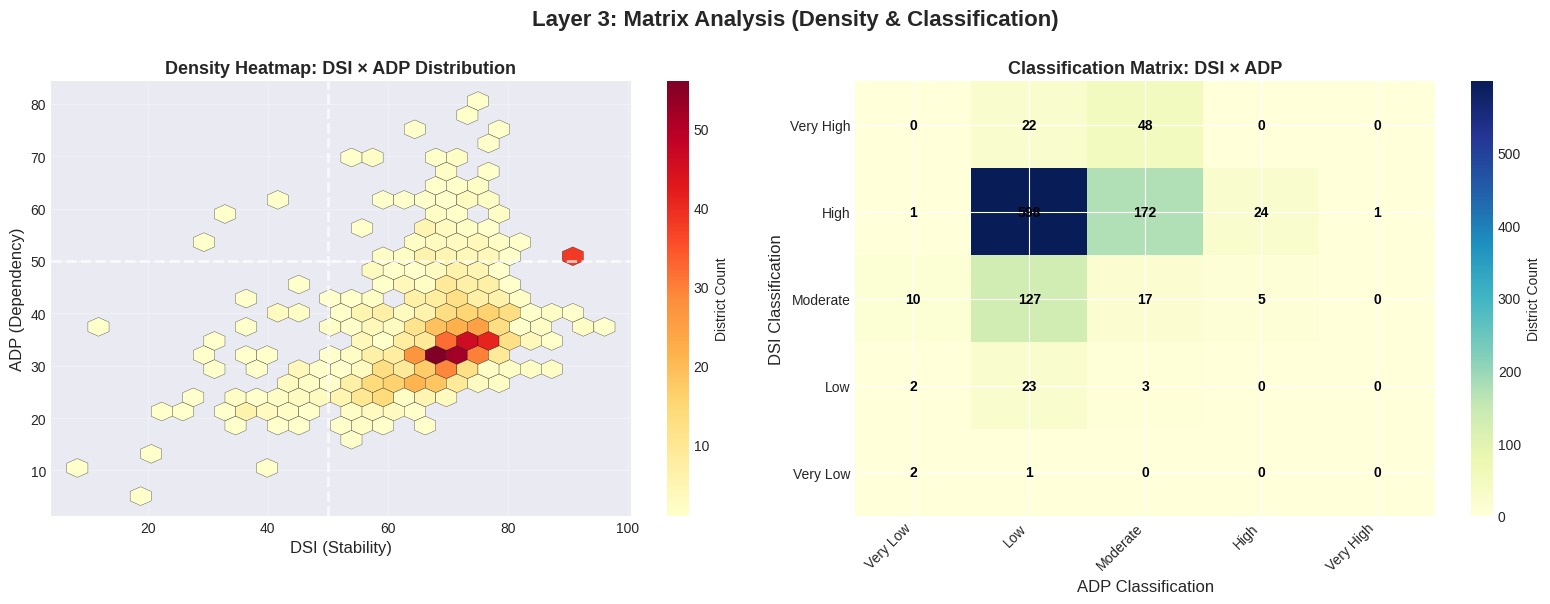

In [12]:
# Create matrix analysis visualization (2 panels)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Layer 3: Matrix Analysis (Density & Classification)', fontsize=16, fontweight='bold', y=1.00)

# Panel 1: Hexbin Density Heatmap
hexbin = axes[0].hexbin(df_adp['DSI'], df_adp['ADP'], gridsize=25, cmap='YlOrRd', mincnt=1, edgecolors='black', linewidths=0.2)
axes[0].axhline(50, color='white', linestyle='--', linewidth=2, alpha=0.7)
axes[0].axvline(50, color='white', linestyle='--', linewidth=2, alpha=0.7)
axes[0].set_xlabel('DSI (Stability)', fontsize=12)
axes[0].set_ylabel('ADP (Dependency)', fontsize=12)
axes[0].set_title('Density Heatmap: DSI × ADP Distribution', fontsize=13, fontweight='bold')
cb1 = plt.colorbar(hexbin, ax=axes[0], label='District Count')
axes[0].grid(alpha=0.3)

# Panel 2: Classification Matrix
classification_matrix = pd.crosstab(df_adp['DSI_Classification'], df_adp['ADP_Classification'])
classification_matrix = classification_matrix.reindex(index=class_order[::-1], columns=class_order, fill_value=0)

im = axes[1].imshow(classification_matrix.values, cmap='YlGnBu', aspect='auto')
axes[1].set_xticks(range(len(class_order)))
axes[1].set_yticks(range(len(class_order)))
axes[1].set_xticklabels(class_order, rotation=45, ha='right')
axes[1].set_yticklabels(class_order[::-1])
axes[1].set_xlabel('ADP Classification', fontsize=12)
axes[1].set_ylabel('DSI Classification', fontsize=12)
axes[1].set_title('Classification Matrix: DSI × ADP', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(len(class_order)):
    for j in range(len(class_order)):
        text = axes[1].text(j, i, int(classification_matrix.values[i, j]),
                           ha="center", va="center", color="black", fontsize=10, fontweight='bold')

cb2 = plt.colorbar(im, ax=axes[1], label='District Count')

plt.tight_layout()
output_path = Path('../outputs/layer3_matrix_analysis.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Matrix analysis saved: {output_path}")
plt.show()

## 9. Export Data Files

In [13]:
# Export full system intelligence dataset
export_columns = [
    'district', 'state', 'DSI', 'DSI_Classification', 'ADP', 'ADP_Classification',
    'Quadrant', 'Critical_Zone', 'coefficient_variation', 'mean_adult_updates',
    'baseline_volume', 'rolling_deviation', 'persistence', 'baseline_score',
    'consistency_score', 'persistence_score'
]

df_export = df_adp[export_columns].copy()
df_export = df_export.sort_values(['state', 'district'])

output_path = Path('../outputs/layer3_system_intelligence.csv')
df_export.to_csv(output_path, index=False)
print(f"✓ Full system intelligence data exported: {output_path}")
print(f"  Total districts: {len(df_export):,}")

✓ Full system intelligence data exported: ../outputs/layer3_system_intelligence.csv
  Total districts: 1,056


In [14]:
# Export critical zones dataset
df_critical = df_adp[df_adp['Critical_Zone']].copy()
critical_columns = [
    'district', 'state', 'DSI', 'DSI_Classification', 'ADP', 'ADP_Classification',
    'coefficient_variation', 'mean_adult_updates', 'rolling_deviation', 'persistence'
]

df_critical_export = df_critical[critical_columns].sort_values('ADP', ascending=False)

output_path = Path('../outputs/layer3_critical_zones.csv')
df_critical_export.to_csv(output_path, index=False)
print(f"✓ Critical zones data exported: {output_path}")
print(f"  Critical districts: {len(df_critical_export):,}")
print(f"  Percentage: {len(df_critical_export) / len(df_export) * 100:.2f}%")

✓ Critical zones data exported: ../outputs/layer3_critical_zones.csv
  Critical districts: 0
  Percentage: 0.00%


## 10. Generate Summary Report

In [15]:
# Generate comprehensive text summary report
report = []
report.append("=" * 80)
report.append("LAYER 3: SYSTEM INTELLIGENCE ANALYSIS REPORT")
report.append("DSI (Demographic Stability Index) & ADP (Aadhaar Dependency Proxy)")
report.append("=" * 80)
report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report.append(f"Total Districts Analyzed: {len(df_export):,}")
report.append("")

# DSI Summary
report.append("-" * 80)
report.append("1. DEMOGRAPHIC STABILITY INDEX (DSI) SUMMARY")
report.append("-" * 80)
report.append(f"Mean DSI: {df_adp['DSI'].mean():.2f}")
report.append(f"Median DSI: {df_adp['DSI'].median():.2f}")
report.append(f"Std Dev: {df_adp['DSI'].std():.2f}")
report.append(f"Min DSI: {df_adp['DSI'].min():.2f} | Max DSI: {df_adp['DSI'].max():.2f}")
report.append("")
report.append("DSI Classification Distribution:")
for classification, count in df_adp['DSI_Classification'].value_counts().reindex(class_order, fill_value=0).items():
    pct = count / len(df_adp) * 100
    report.append(f"  {classification:12s}: {count:4d} districts ({pct:5.2f}%)")
report.append("")

# Top 10 Most Stable
report.append("Top 10 Most Stable Districts (Highest DSI):")
for idx, row in df_adp.nlargest(10, 'DSI').iterrows():
    report.append(f"  {row['district']:30s} ({row['state']:20s}): DSI = {row['DSI']:.2f}")
report.append("")

# ADP Summary
report.append("-" * 80)
report.append("2. AADHAAR DEPENDENCY PROXY (ADP) SUMMARY")
report.append("-" * 80)
report.append(f"Mean ADP: {df_adp['ADP'].mean():.2f}")
report.append(f"Median ADP: {df_adp['ADP'].median():.2f}")
report.append(f"Std Dev: {df_adp['ADP'].std():.2f}")
report.append(f"Min ADP: {df_adp['ADP'].min():.2f} | Max ADP: {df_adp['ADP'].max():.2f}")
report.append("")
report.append("ADP Classification Distribution:")
for classification, count in df_adp['ADP_Classification'].value_counts().reindex(class_order, fill_value=0).items():
    pct = count / len(df_adp) * 100
    report.append(f"  {classification:12s}: {count:4d} districts ({pct:5.2f}%)")
report.append("")

# Top 10 Highest Dependency
report.append("Top 10 Highest Dependency Districts (Highest ADP):")
for idx, row in df_adp.nlargest(10, 'ADP').iterrows():
    report.append(f"  {row['district']:30s} ({row['state']:20s}): ADP = {row['ADP']:.2f}")
report.append("")

# Integrated Analysis
report.append("-" * 80)
report.append("3. INTEGRATED SYSTEM INTELLIGENCE ANALYSIS")
report.append("-" * 80)
report.append("Quadrant Distribution:")
for quadrant, count in df_adp['Quadrant'].value_counts().items():
    pct = count / len(df_adp) * 100
    report.append(f"  {quadrant:40s}: {count:4d} districts ({pct:5.2f}%)")
report.append("")

# Critical Zones
report.append("-" * 80)
report.append("4. CRITICAL ZONES ANALYSIS (ADP >= 60 and DSI < 40)")
report.append("-" * 80)
critical_count = df_adp['Critical_Zone'].sum()
critical_pct = critical_count / len(df_adp) * 100
report.append(f"Total Critical Zone Districts: {critical_count:,} ({critical_pct:.2f}% of total)")
report.append("")

if critical_count > 0:
    report.append("Critical Zone Districts (Top 20 by ADP):")
    for idx, row in df_adp[df_adp['Critical_Zone']].nlargest(20, 'ADP').iterrows():
        report.append(f"  {row['district']:30s} ({row['state']:20s}): ADP={row['ADP']:.2f}, DSI={row['DSI']:.2f}")
    report.append("")
    
    # Critical zones by state
    critical_by_state = df_adp[df_adp['Critical_Zone']].groupby('state').size().sort_values(ascending=False)
    report.append("Critical Zones by State (Top 10):")
    for state, count in critical_by_state.head(10).items():
        report.append(f"  {state:30s}: {count:3d} districts")
else:
    report.append("No districts identified in critical zones.")
report.append("")

# State-level Analysis
report.append("-" * 80)
report.append("5. STATE-LEVEL AGGREGATION (Top 15 by District Count)")
report.append("-" * 80)
state_agg_full = df_adp.groupby('state').agg({
    'DSI': 'mean',
    'ADP': 'mean',
    'district': 'count'
}).rename(columns={'district': 'num_districts'}).sort_values('num_districts', ascending=False).head(15)

report.append(f"{'State':30s} {'Districts':>10s} {'Avg DSI':>10s} {'Avg ADP':>10s}")
report.append("-" * 65)
for state, row in state_agg_full.iterrows():
    report.append(f"{state:30s} {int(row['num_districts']):10d} {row['DSI']:10.2f} {row['ADP']:10.2f}")
report.append("")

# Methodology
report.append("-" * 80)
report.append("6. METHODOLOGY")
report.append("-" * 80)
report.append("DSI Calculation:")
report.append("  DSI = (0.6 * (1 - normalized_CV) + 0.4 * (1 - normalized_deviation)) * 100")
report.append("  - Higher DSI = More demographic stability")
report.append("  - Based on coefficient of variation and rolling 3-month deviation")
report.append("")
report.append("ADP Calculation:")
report.append("  ADP = 0.50 * baseline_score + 0.30 * consistency_score + 0.20 * persistence_score")
report.append("  - Higher ADP = Greater Aadhaar system dependency")
report.append("  - Baseline: normalized mean adult updates")
report.append("  - Consistency: inverse of coefficient of variation")
report.append("  - Persistence: % of months above mean")
report.append("")

# Files Generated
report.append("-" * 80)
report.append("7. OUTPUT FILES GENERATED")
report.append("-" * 80)
report.append("Visualizations:")
report.append("  - layer3_dsi_analysis.png (4 panels)")
report.append("  - layer3_adp_analysis.png (4 panels)")
report.append("  - layer3_integrated_analysis.png (4 panels)")
report.append("  - layer3_matrix_analysis.png (2 panels)")
report.append("")
report.append("Data Exports:")
report.append("  - layer3_system_intelligence.csv (all districts)")
report.append("  - layer3_critical_zones.csv (critical districts)")
report.append("")
report.append("Reports:")
report.append("  - layer3_summary_report.txt (this file)")
report.append("")
report.append("=" * 80)
report.append("END OF REPORT")
report.append("=" * 80)

# Write report to file
report_text = "\n".join(report)
output_path = Path('../outputs/layer3_summary_report.txt')
with open(output_path, 'w') as f:
    f.write(report_text)

print(f"✓ Summary report generated: {output_path}")
print("\n" + "=" * 80)
print(report_text)
print("=" * 80)

✓ Summary report generated: ../outputs/layer3_summary_report.txt

LAYER 3: SYSTEM INTELLIGENCE ANALYSIS REPORT
DSI (Demographic Stability Index) & ADP (Aadhaar Dependency Proxy)
Generated: 2026-01-15 20:00:15
Total Districts Analyzed: 1,056

--------------------------------------------------------------------------------
1. DEMOGRAPHIC STABILITY INDEX (DSI) SUMMARY
--------------------------------------------------------------------------------
Mean DSI: 68.19
Median DSI: 69.81
Std Dev: 11.01
Min DSI: 8.28 | Max DSI: 96.11

DSI Classification Distribution:
  Very Low    :    3 districts ( 0.28%)
  Low         :   28 districts ( 2.65%)
  Moderate    :  159 districts (15.06%)
  High        :  796 districts (75.38%)
  Very High   :   70 districts ( 6.63%)

Top 10 Most Stable Districts (Highest DSI):
  Kalahandi                      (Orissa              ): DSI = 96.11
  Raebareli                      (Uttar Pradesh       ): DSI = 94.19
  Hooghiy                        (West Bengal         

## 11. Summary and Validation

In [16]:
# Final validation and summary
print("\n" + "=" * 80)
print("LAYER 3: SYSTEM INTELLIGENCE ANALYSIS COMPLETE")
print("=" * 80)
print(f"\n✓ Analysis completed successfully")
print(f"✓ Total districts analyzed: {len(df_export):,}")
print(f"✓ Critical zones identified: {critical_count:,} ({critical_pct:.2f}%)")
print("\n" + "-" * 80)
print("OUTPUT FILES GENERATED:")
print("-" * 80)

output_files = [
    '../outputs/layer3_dsi_analysis.png',
    '../outputs/layer3_adp_analysis.png',
    '../outputs/layer3_integrated_analysis.png',
    '../outputs/layer3_matrix_analysis.png',
    '../outputs/layer3_system_intelligence.csv',
    '../outputs/layer3_critical_zones.csv',
    '../outputs/layer3_summary_report.txt'
]

for file in output_files:
    file_path = Path(file)
    if file_path.exists():
        size = file_path.stat().st_size
        if size > 1024 * 1024:
            size_str = f"{size / (1024*1024):.2f} MB"
        elif size > 1024:
            size_str = f"{size / 1024:.2f} KB"
        else:
            size_str = f"{size} bytes"
        print(f"✓ {file_path.name:45s} ({size_str})")
    else:
        print(f"✗ {file_path.name:45s} (NOT FOUND)")

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print(f"1. Average DSI (Stability): {df_adp['DSI'].mean():.2f}/100")
print(f"2. Average ADP (Dependency): {df_adp['ADP'].mean():.2f}/100")
print(f"3. Most stable district: {df_adp.loc[df_adp['DSI'].idxmax(), 'district']}, {df_adp.loc[df_adp['DSI'].idxmax(), 'state']} (DSI={df_adp['DSI'].max():.2f})")
print(f"4. Highest dependency district: {df_adp.loc[df_adp['ADP'].idxmax(), 'district']}, {df_adp.loc[df_adp['ADP'].idxmax(), 'state']} (ADP={df_adp['ADP'].max():.2f})")
print(f"5. Critical zones requiring attention: {critical_count:,} districts")
print("\n" + "=" * 80)


LAYER 3: SYSTEM INTELLIGENCE ANALYSIS COMPLETE

✓ Analysis completed successfully
✓ Total districts analyzed: 1,056
✓ Critical zones identified: 0 (0.00%)

--------------------------------------------------------------------------------
OUTPUT FILES GENERATED:
--------------------------------------------------------------------------------
✓ layer3_dsi_analysis.png                       (820.60 KB)
✓ layer3_adp_analysis.png                       (984.17 KB)
✓ layer3_integrated_analysis.png                (1.25 MB)
✓ layer3_matrix_analysis.png                    (466.60 KB)
✓ layer3_system_intelligence.csv                (231.27 KB)
✓ layer3_critical_zones.csv                     (132 bytes)
✓ layer3_summary_report.txt                     (6.21 KB)

KEY INSIGHTS:
1. Average DSI (Stability): 68.19/100
2. Average ADP (Dependency): 36.04/100
3. Most stable district: Kalahandi, Orissa (DSI=96.11)
4. Highest dependency district: East Champaran, Bihar (ADP=80.52)
5. Critical zones requiring 